# Comparison of SBP-SAT and SPECFEM2D in a two-layers medium

### Note1: all commands starting with '!' can be run directly from the command line (in case it doesn't work from the Notebook).

### Note2: If running within a Docker, no action is needed. If not, add the installation path (e.g. 'path_to_fwi2d_directory/local/bin') to the environment variable 'PATH' or prepend every executable with the above path.

In [1]:
import numpy as np
from scipy import signal
import math
import matplotlib.pyplot as plt
from matplotlib import rcParams

Create directories to store data and figures

In [2]:
!mkdir -p ../dat ../fig

Illegal variable name.


### Generate source wavelet (Ricker)

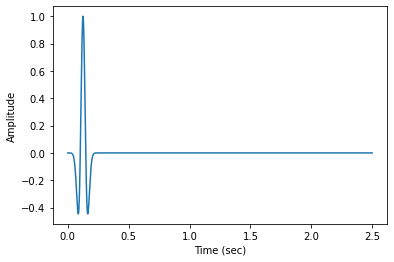

In [3]:
nt=5001
dt=0.0005
ot=0
wc=0.01
sigma=math.sqrt(2)/(math.pi*wc)
src1 = signal.ricker(2*nt-1, sigma)
src1=src1[4750:4750+nt]
src1=src1*1.0/np.max(src1)

plt.plot(np.linspace(ot,(nt-1)*dt,nt),src1)
plt.xlabel("Time (sec)")
plt.ylabel("Amplitude")
plt.show()

In [4]:
# save to text file for SPECFEM2D
file = open('../dat/src1.txt', 'w')
for i in range(nt):
    print("%.6f %.6f" %(i*dt+ot,src1[i]), file=file)
file.close()

# save to numpy
np.save('../dat/src1',src1)

# convert to SEPlib for SBP-SAT
!sep2numpy.py --input ../dat/src1.npy --mode 1 --datapath ${PWD}/../dat/ --output ../dat/src1.H

# set the sampling (in sec) in the description file
!echo d1=0.0005 >> ../dat/src1.H

Illegal variable name.
Illegal variable name.


### Generate a homogeneous isotropic elastic model

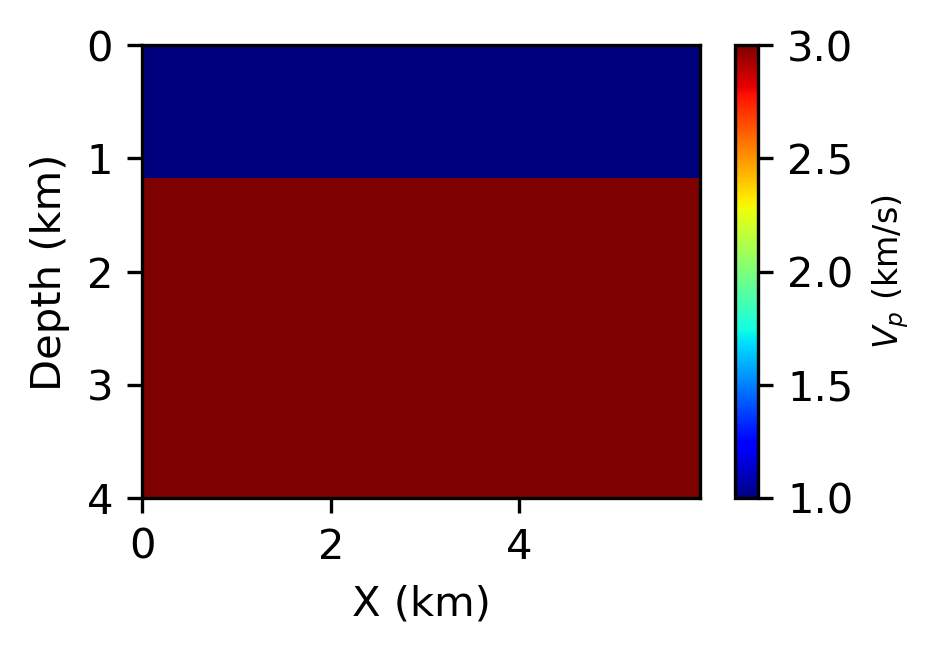

In [5]:
# elastic model
emodel=np.zeros((3,1201,577))
emodel[0,:,:]=3 # Vp in km/s
emodel[1,:,:]=1 # Vs in km/s
emodel[2,:,:]=2.5 # Density in g/cc

# full Vp model for plotting (acoustic on top then elastic)
aemodel=np.full((1201,818),3)
aemodel[:,:241]=1.5

fig, ax = plt.subplots(1,1,figsize=(3, 2),dpi=300)
im=ax.imshow(np.transpose(aemodel),interpolation='none',aspect="auto",extent=[0,5.92,4,0],cmap='jet')
ax.set(xlabel='X (km)')
ax.set(ylabel='Depth (km)')
cbar=fig.colorbar(im, ax=ax,format='%.'+str(1)+'f',aspect=20)
cbar.set_label(label=r'$V_p$ (km/s)',size=8)

In [6]:
# save to numpy
np.save('../dat/emodel1',emodel)

# convert to SEPlib for SBP-SAT
!sep2numpy.py --input ../dat/emodel1.npy --output ../dat/emodel1.H --mode 1 --datapath ${PWD}/../dat/
!echo o1=1.12 d1=0.005 d2=0.005 >> ../dat/emodel1.H

Illegal variable name.
Illegal variable name.


### Run modeling using SPECFEM2D

In [7]:
# generate particle velocity recordings
!bash ../specfem2d/run_v.sh

Illegal variable name.
running SPECFEM2D to model particle velocity with provided source time function in txt file: Tue Jul 12 14:27:40 PDT 2022
/homes/sep/nmbader/publications/GEOPHYSICS2022/notebooks


(will take about 5 minutes)


   setting up the test


  running mesher...

../specfem2d/run_v.sh: line 52: ./xmeshfem2D: No such file or directory

  running solver...

../specfem2d/run_v.sh: line 58: ./xspecfem2D: No such file or directory
cp: cannot stat ‘DATA/*STATIONS*’: No such file or directory

see results in directory: OUTPUT_FILES/

done
Tue Jul 12 14:27:43 PDT 2022


In [8]:
# copy the output
!cp ../dat/OUTPUT_FILES/AA.S0001.BXX.semd ../dat/specfem2d_data_vx.txt
!cp ../dat/OUTPUT_FILES/AA.S0001.BXZ.semd ../dat/specfem2d_data_vz.txt

Illegal variable name.
cp: cannot stat ‘../dat/OUTPUT_FILES/AA.S0001.BXX.semd’: No such file or directory
Illegal variable name.
cp: cannot stat ‘../dat/OUTPUT_FILES/AA.S0001.BXZ.semd’: No such file or directory


In [9]:
# generate pressure recording
!bash ../specfem2d/run_p.sh

Illegal variable name.
running SPECFEM2D to model particle velocity with provided source time function in txt file: Tue Jul 12 14:27:45 PDT 2022
/homes/sep/nmbader/publications/GEOPHYSICS2022/notebooks


(will take about 5 minutes)


   setting up the test


  running mesher...

../specfem2d/run_p.sh: line 52: ./xmeshfem2D: No such file or directory

  running solver...

../specfem2d/run_p.sh: line 58: ./xspecfem2D: No such file or directory
cp: cannot stat ‘DATA/*STATIONS*’: No such file or directory

see results in directory: OUTPUT_FILES/

done
Tue Jul 12 14:27:45 PDT 2022


In [10]:
# copy the output
!cp ../dat/OUTPUT_FILES/AA.S0001.PRE.semp ../dat/specfem2d_data_p.txt

Illegal variable name.
cp: cannot stat ‘../dat/OUTPUT_FILES/AA.S0001.PRE.semp’: No such file or directory


### Run modeling using FWI2D

In [11]:
!WE_MODELING.x source=../dat/src1.H model=../dat/emodel1.H output=../dat/fd_data.H datapath=${PWD}/../dat/ wavefield=../dat/fd_data.H.wfld acoustic_elastic=1 acoustic_source=1 acoustic_wavefield=1 water_velocity=1.5 water_density=1 \
dt=0.0005 resampling=linear sub=100 fmax=30 verbose=3 \
ns=1 sx0=2.4 sz0=1.04 nr=1 rx0=3.44 rz0=1.12 seismotype=1 \
bc_top=1 free_surface_stiffness=1.4 bc_bottom=2 bc_left=2 bc_right=2 taper_top=0 taper_bottom=100 taper_left=100 taper_right=100 taper_strength=0.1
!echo esize=4 >> ../dat/fd_data.H
!echo esize=4 >> ../dat/fd_data.H.wfld
!echo esize=4 >> ../dat/fd_data.H.wflda

Illegal variable name.

 Subsurface model geometry
xmin=0.00000 km, xmax=6.00000 km, dx=0.00500 km, nx=1201
zmin=1.12000 km, zmax=4.00000 km, dz=0.00500 km, nz=577
A fluid layer is implicitly added on top of the model, all the way up to z=0 km with nz=225 samples v=1.50 km/s and rho=1.00 g/cc

 Boundary conditions
Top boundary condition = free surface	 taper size = 0	 taper type = none
Bottom boundary condition = locally absorbing	 taper size = 100	 taper type = cosine squared
Left boundary condition = locally absorbing	 taper size = 100	 taper type = cosine squared
Right boundary condition = locally absorbing	 taper size = 100	 taper type = cosine squared

 Sources' and receivers' geometry
Sources' and receivers' coordinates are read from parameters list
Receivers are dual point measurement of type hydraulic pressure and particle velocity
Number of sources = 1
All sources must fall within the fluid layer
Shot 0 located at x=2.40000 km, z=1.04000 km, has 1 receivers
Total number of 3-c

In [19]:
# convert to numpy
!sep2numpy.py --input ../dat/fd_data.H --output ../dat/fd_data --mode 0
!sep2numpy.py --input ../dat/fd_data.H.wfld --output ../dat/fd_data.wfld --mode 0
!sep2numpy.py --input ../dat/fd_data.H.wflda --output ../dat/fd_data.wflda --mode 0

### Wavefield figures

In [21]:
# load acoustic and elastic wavefields generated by SBP-SAT method
awfld = np.load('../dat/fd_data.wflda.npy') # fluid momentum potential
ewfld = np.load('../dat/fd_data.wfld.npy') # solid particle displacement

In [22]:
# compute particle velocity magnitude in each medium and concatenate the two wavefields for two given time snapshots
it1 = 12
it2 = 24
dt=0.0005
sub=100
awfld1=awfld[it1,:,:]
awfld2=awfld[it2,:,:]
ewfld1=(ewfld[it1+1,:,:,:]-ewfld[it1-1,:,:,:])/(2*sub*dt)
ewfld2=(ewfld[it2+1,:,:,:]-ewfld[it2-1,:,:,:])/(2*sub*dt)

# the gradient of the acoustic wavefield (momentum potential) divided by water density (=1 in this case) yields particle velocity in the acoustic medium
dx=0.005
dz=0.005
va1 = np.gradient(awfld1,dx,dz)
va2 = np.gradient(awfld2,dx,dz)

va1 = np.sqrt(np.square(va1[0])+np.square(va1[1]))
va2 = np.sqrt(np.square(va2[0])+np.square(va2[1]))
ve1 = np.sqrt(np.square(ewfld1[0,:,:])+np.square(ewfld1[1,:,:]))
ve2 = np.sqrt(np.square(ewfld2[0,:,:])+np.square(ewfld2[1,:,:]))

v1 = np.concatenate((va1,ve1),axis=1)
v2 = np.concatenate((va2,ve2),axis=1)

Text(3.2, 0.6, 'D')

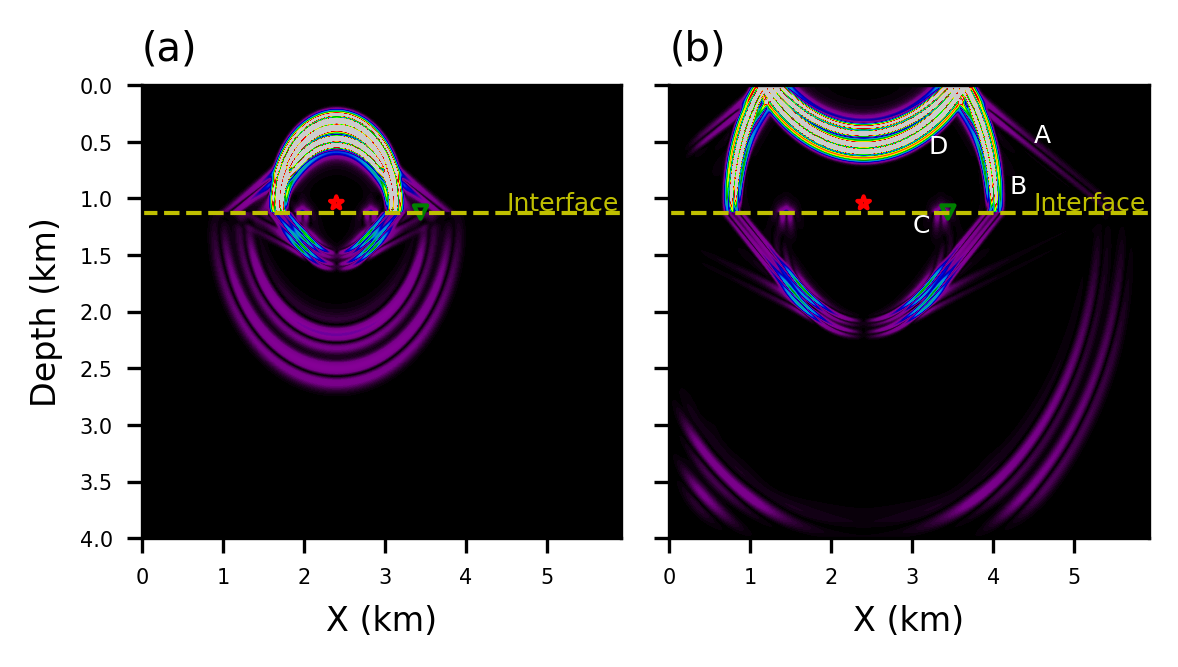

In [23]:
%matplotlib inline

rcParams['font.size'] = 8
rcParams['font.family'] = 'sans-serif'

fig, ax = plt.subplots(1,2,figsize=(4.33, 2),dpi=300)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0)
im1=ax[0].imshow(np.transpose(v1),interpolation='bilinear',aspect="auto",extent=[0,5.92,4,0],vmin=0,vmax=0.4,cmap='nipy_spectral')
im2=ax[1].imshow(np.transpose(v2),interpolation='bilinear',aspect="auto",extent=[0,5.92,4,0],vmin=0,vmax=0.4,cmap='nipy_spectral')
ax[0].set(xlabel='X (km)',ylabel='Depth (km)')
ax[1].set(xlabel='X (km)')
#ax[0].set_title('(a) t=0.7 sec',loc='center',y=-0.5)
#ax[1].set_title('(b) t=1.2 sec',loc='center',y=-0.5)
#ax[0].set_title('(a) t=0.7 sec',loc='center')
#ax[1].set_title('(b) t=1.2 sec',loc='center')
ax[0].set_title('(a)',loc='left')
ax[1].set_title('(b)',loc='left')
ax[0].tick_params(axis='both', which='major', labelsize=5)
ax[1].tick_params(axis='both', which='major', labelsize=5)
ax[1].set_yticklabels([])

ax[0].hlines(1.125,0,5.92,colors='y',linestyles='--',Linewidth=1)
ax[0].scatter([2.4], [1.04],marker='*',edgecolors='r',facecolors='none',s=10)
ax[0].scatter([3.44],[1.12],marker='v',edgecolors='g',facecolors='none',s=10)
ax[1].hlines(1.125,0,5.92,colors='y',linestyles='--',Linewidth=1)
ax[1].scatter([2.4], [1.04],marker='*',edgecolors='r',facecolors='none',s=10)
ax[1].scatter([3.44],[1.12],marker='v',edgecolors='g',facecolors='none',s=10)

ax[0].annotate('Interface',xy=(4.5,1.1),fontsize=6,c='y')
ax[1].annotate('Interface',xy=(4.5,1.1),fontsize=6,c='y')
ax[1].annotate("A",xy=(4.5,0.5),c='w',fontsize=6)
ax[1].annotate("B",xy=(4.2,0.95),c='w',fontsize=6)
ax[1].annotate("C",xy=(3,1.3),c='w',fontsize=6)
ax[1].annotate("D",xy=(3.2,0.6),c='w',fontsize=6)
#ax[1].annotate("E",xy=(3,3.4),c='w',fontsize=6)
#ax[1].annotate("E",xy=(0.8,3),c='w',fontsize=6)

#plt.show()
#plt.savefig(figpath+'wavefields.png',bbox_inches='tight',format='png')

### Seismogram figures

In [27]:
# load SBP-SAT and SPECFEM2D seismograms
fd=np.load('../dat/fd_data.npy')
spec_vx=np.loadtxt('../dat/specfem2d_data_vx.txt')
spec_vz=np.loadtxt('../dat/specfem2d_data_vz.txt')
spec_p=np.loadtxt('../dat/specfem2d_data_p.txt')

# calibrate SPECFEM2D amplitudes (because different physical units are used)
spec_vx=2.25*10**12*spec_vx[:,1]
spec_vz=-2.25*10**12*spec_vz[:,1]
spec_p=-2.25*10**6*np.gradient(spec_p[:,1],dt) # from fluid potential to calibrated hydraulic pressure

Text(1.62, 0.4, 'D')

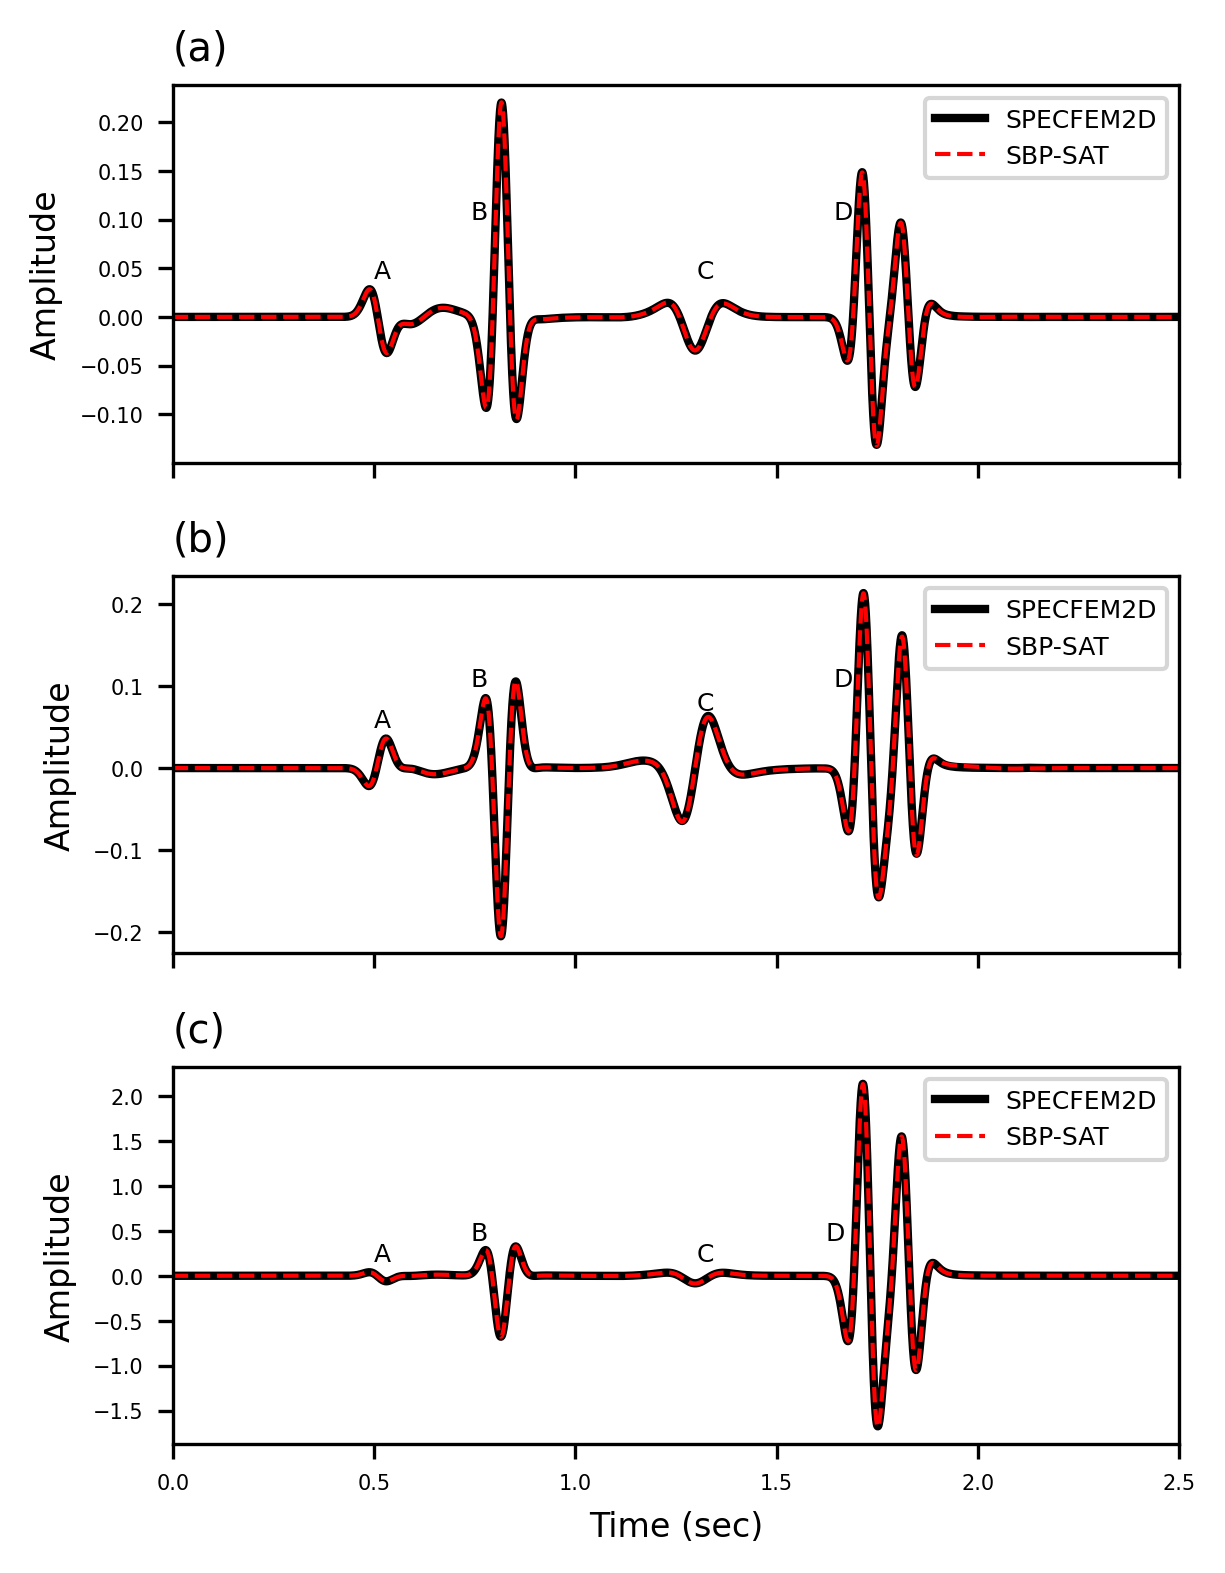

In [28]:
%matplotlib inline

rcParams['font.size'] = 8
rcParams['font.family'] = 'sans-serif'

fig, ax = plt.subplots(3,1,figsize=(4.33, 6),dpi=300)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.3)
l,=ax[0].plot(np.linspace(ot,(nt-1)*dt,nt),spec_vx,linestyle='-',linewidth=2,c='k')
l.set_label("SPECFEM2D")
l,=ax[0].plot(np.linspace(ot,(nt-1)*dt,nt),fd[1,0,:],linestyle='--',linewidth=1,c='r')
l.set_label("SBP-SAT")
l,=ax[1].plot(np.linspace(ot,(nt-1)*dt,nt),spec_vz,linestyle='-',linewidth=2,c='k')
l.set_label("SPECFEM2D")
l,=ax[1].plot(np.linspace(ot,(nt-1)*dt,nt),fd[2,0,:],linestyle='--',linewidth=1,c='r')
l.set_label("SBP-SAT")
l,=ax[2].plot(np.linspace(ot,(nt-1)*dt,nt),spec_p,linestyle='-',linewidth=2,c='k')
l.set_label("SPECFEM2D")
l,=ax[2].plot(np.linspace(ot,(nt-1)*dt,nt),fd[0,0,:],linestyle='--',linewidth=1,c='r')
l.set_label("SBP-SAT")

ax[0].set_xlim(0,ot+(nt-1)*dt)
ax[1].set_xlim(0,ot+(nt-1)*dt)
ax[2].set_xlim(0,ot+(nt-1)*dt)

ax[0].set(ylabel='Amplitude')
ax[1].set(ylabel='Amplitude')
ax[2].set(xlabel='Time (sec)',ylabel='Amplitude')

#ax[0].set_title(r'(a) $v_x$ component',loc='left')
#ax[1].set_title(r'(b) $v_z$ component',loc='left')
#ax[2].set_title(r'(c) Pressure component',loc='left')
ax[0].set_title(r'(a)',loc='left')
ax[1].set_title(r'(b)',loc='left')
ax[2].set_title(r'(c)',loc='left')

ax[0].tick_params(axis='both', which='major', labelsize=5)
ax[1].tick_params(axis='both', which='major', labelsize=5)
ax[2].tick_params(axis='both', which='major', labelsize=5)

ax[0].set_xticklabels([])
ax[1].set_xticklabels([])

ax[0].legend(loc='upper right',prop={'size': 6})
ax[1].legend(loc='upper right',prop={'size': 6})
ax[2].legend(loc='upper right',prop={'size': 6})

ax[0].annotate("A",xy=(0.5,0.04),c='k',fontsize=6)
ax[0].annotate("B",xy=(0.74,0.1),c='k',fontsize=6)
ax[0].annotate("C",xy=(1.3,0.04),c='k',fontsize=6)
ax[0].annotate("D",xy=(1.64,0.1),c='k',fontsize=6)

ax[1].annotate("A",xy=(0.5,0.05),c='k',fontsize=6)
ax[1].annotate("B",xy=(0.74,0.1),c='k',fontsize=6)
ax[1].annotate("C",xy=(1.3,0.07),c='k',fontsize=6)
ax[1].annotate("D",xy=(1.64,0.1),c='k',fontsize=6)

ax[2].annotate("A",xy=(0.5,0.16),c='k',fontsize=6)
ax[2].annotate("B",xy=(0.74,0.4),c='k',fontsize=6)
ax[2].annotate("C",xy=(1.3,0.16),c='k',fontsize=6)
ax[2].annotate("D",xy=(1.62,0.4),c='k',fontsize=6)

#plt.show()
#plt.savefig(figpath+'seismograms.png',bbox_inches='tight',format='png')